<a href="https://colab.research.google.com/github/conel77/pytorchwikidocs_training/blob/main/animal_sorting_usingResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [ ]:
import urllib.request
import zipfile
import glob
import os
import random
from PIL import Image, UnidentifiedImageError,ImageFile

SEED = 123

In [ ]:
import torchvision
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor
from torchvision.transforms import RandomHorizontalFlip, RandomCrop
from torchvision.transforms import Normalize
from torch.utils.data.dataloader import DataLoader

from torch.utils.data import Dataset
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np

from torch.optim.adam import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data =  torchvision.datasets.ImageFolder('drive/MyDrive/work/train_c', transform= transforms)




In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def validate_image(filepath):
    try:

        img = Image.open(filepath).convert('RGB')
        img.load()
    except UnidentifiedImageError: # corrupt 된 이미지는 해당 에러를 출력
        print(f'Corrupted Image is found at: {filepath}')
        return False
    except (IOError, OSError): # Truncated (잘린) 이미지에 대한 에러를 출력
        print(f'Truncated Image is found at: {filepath}')
        return False
    else:
        return True

In [ ]:
# image 데이터셋 root 폴더
root = 'drive/MyDrive/work/train_c' 

dirs = os.listdir(root)

for dir_ in dirs:
    folder_path = os.path.join(root, dir_)
    files = os.listdir(folder_path)
    
    images = [os.path.join(folder_path, f) for f in files]
    for img in images:
        valid = validate_image(img)
        if not valid:
            # corrupted 된 이미지 제거
            os.remove(img)


In [ ]:
import glob

path = 'drive/MyDrive/work/train_c/*' 
folders = glob.glob(path)

folders

['drive/MyDrive/work/train_c/humans',
 'drive/MyDrive/work/train_c/horses',
 'drive/MyDrive/work/train_c/cats',
 'drive/MyDrive/work/train_c/dogs']

In [ ]:
# train: test ratio. 0.2로 설정시 test set의 비율은 20%로 설정
test_size = 0.2

# train / test 셋의 파일을 나눕니다.
train_images = []
test_images = []

for folder in folders:
    label = os.path.basename(folder)
    files = sorted(glob.glob(folder + '/*'))

    # 각 Label별 이미지 데이터셋 셔플
    random.seed(SEED)
    random.shuffle(files)

    idx = int(len(files) * test_size)
    train = files[:-idx]
    test = files[-idx:]

    train_images.extend(train)
    test_images.extend(test)

# train, test 전체 이미지 셔플
random.shuffle(train_images)
random.shuffle(test_images)

# Class to Index 생성. {'Dog': 0, 'Cat': 1}
class_to_idx = {os.path.basename(f):idx for idx, f in enumerate(folders)}

# Label 생성
train_labels = [f.split('/')[-2] for f in train_images]
test_labels = [f.split('/')[-2] for f in test_images]

print('==='*10)
print(f'train images: {len(train_images)}')
print(f'train labels: {len(train_labels)}')
print(f'test images: {len(test_images)}')
print(f'test labels: {len(test_labels)}')

train images: 1622
train labels: 1622
test images: 405
test labels: 405


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, files, labels, class_to_idx, transform):
        super(CustomImageDataset, self).__init__()
        self.files = files
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        # file 경로
        file = self.files[idx]
        # PIL.Image로 이미지 로드
        img = Image.open(file).convert('RGB')
        # transform 적용
        img = self.transform(img)
        # label 생성
        lbl = self.class_to_idx[self.labels[idx]]
        # image, label return
        return img, lbl

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),          # 개와 고양이 사진 파일의 크기가 다르므로, Resize
    transforms.CenterCrop((224, 224)),      # 중앙 Crop
    transforms.RandomHorizontalFlip(0.5),   # 50% 확률로 Horizontal Flip
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),      # 개와 고양이 사진 파일의 크기가 다르므로, Resize
    transforms.ToTensor(), 
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # 이미지 정규화
])

In [ ]:
# train, test 데이터셋 생성
train_dataset = CustomImageDataset(train_images, train_labels, class_to_idx, train_transform)
test_dataset = CustomImageDataset(test_images, test_labels, class_to_idx, test_transform)

In [ ]:
# train, test 데이터 로더 생성 => 모델 학습시 입력하는 데이터셋
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True,
                          num_workers=8
                         )

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=True,
                         num_workers=8
                        )

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
images[0].shape

torch.Size([3, 224, 224])

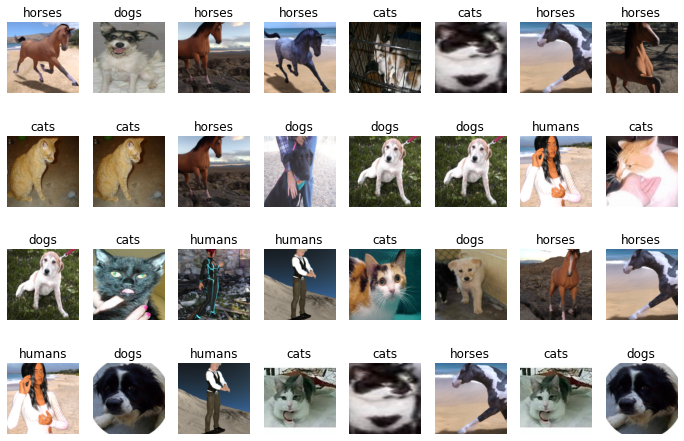

In [ ]:
import matplotlib.pyplot as plt

# ImageFolder의 속성 값인 class_to_idx를 할당
labels_map = {v:k for k, v in train_dataset.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 4

# 이미지를 출력합니다. RGB 이미지로 구성
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    # 본래 이미지의 shape은 (3, 300, 300) 
    # 이를 imshow() 함수로 이미지 시각화 하기 위하여 (300, 300, 3)으로 shape 변경을 한 후 시각화
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [ ]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from torchvision import models # pretrained 모델을 가져오기 위한 import

# ResNet101 모델 생성
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn


# Fully-Connected Layer를 Sequential로 생성하여 VGG pretrained 모델의 'Classifier'에 연결
fc = nn.Sequential(
    nn.Linear(2048, 256), # VGG16 모델의 features의 출력이 7X7, 512장 이기 때문에 in_features=7*7*512 로 설정
    nn.ReLU(), 
    nn.Linear(256, 64), 
    nn.ReLU(), 
    nn.Linear(64, 4),
)

In [ ]:
model.fc = fc
model.to(device)
# 모델의 구조도 출력
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0005)


loss_fn = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):

    model.train()
    

    running_loss = 0
    corr = 0
    

    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작
    for img, lbl in prograss_bar:
 
        img, lbl = img.to(device), lbl.to(device)
        
  
        optimizer.zero_grad()
        
      
        output = model(img)
        
       
        loss = loss_fn(output, lbl)
        
        
        loss.backward()
        
       
        optimizer.step()
        
      
       
        _, pred = output.max(dim=1)
        
     
        corr += pred.eq(lbl).sum().item()
        
      
        running_loss += loss.item() * img.size(0)
        
  
    acc = corr / len(data_loader.dataset)
    
    return running_loss / len(data_loader.dataset), acc

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
   
    model.eval()
    
   
    with torch.no_grad():
     
        corr = 0
        running_loss = 0
       
        for img, lbl in data_loader:
          
            img, lbl = img.to(device), lbl.to(device)
            
         
            output = model(img)
            
       
            _, pred = output.max(dim=1)
          
            corr += torch.sum(pred.eq(lbl)).item()
            
         
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
     
        acc = corr / len(data_loader.dataset)
        
     
        return running_loss / len(data_loader.dataset), acc

In [ ]:
# 최대 Epoch을 지정합니다.
num_epochs = 10
model_name = 'vgg16-pretrained'

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), f'{model_name}.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 51/51 [09:05<00:00, 10.69s/it]


[INFO] val_loss has been improved from inf to 0.04510. Saving Model!
epoch 01, loss: 0.37666, acc: 0.94451, val_loss: 0.04510, val_accuracy: 0.98519


100%|██████████| 51/51 [09:08<00:00, 10.75s/it]


[INFO] val_loss has been improved from 0.04510 to 0.03563. Saving Model!
epoch 02, loss: 0.05867, acc: 0.98212, val_loss: 0.03563, val_accuracy: 0.98765


100%|██████████| 51/51 [09:07<00:00, 10.74s/it]


[INFO] val_loss has been improved from 0.03563 to 0.03118. Saving Model!
epoch 03, loss: 0.03068, acc: 0.99075, val_loss: 0.03118, val_accuracy: 0.99012


100%|██████████| 51/51 [09:08<00:00, 10.75s/it]


epoch 04, loss: 0.03051, acc: 0.99260, val_loss: 0.03229, val_accuracy: 0.98519


100%|██████████| 51/51 [09:06<00:00, 10.72s/it]


[INFO] val_loss has been improved from 0.03118 to 0.02426. Saving Model!
epoch 05, loss: 0.01706, acc: 0.99507, val_loss: 0.02426, val_accuracy: 0.98765


100%|██████████| 51/51 [09:49<00:00, 11.57s/it]


epoch 06, loss: 0.01282, acc: 0.99507, val_loss: 0.06227, val_accuracy: 0.98765


100%|██████████| 51/51 [09:10<00:00, 10.79s/it]


epoch 07, loss: 0.01231, acc: 0.99630, val_loss: 0.03303, val_accuracy: 0.98519


100%|██████████| 51/51 [09:18<00:00, 10.95s/it]


epoch 08, loss: 0.01846, acc: 0.99322, val_loss: 0.06284, val_accuracy: 0.98519


100%|██████████| 51/51 [09:13<00:00, 10.86s/it]


epoch 09, loss: 0.00660, acc: 0.99877, val_loss: 0.02833, val_accuracy: 0.99506


100%|██████████| 51/51 [09:22<00:00, 11.04s/it]


epoch 10, loss: 0.01161, acc: 0.99568, val_loss: 0.04898, val_accuracy: 0.97531


In [ ]:
model.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [ ]:
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.02426, evaluation accuracy: 0.98765
